# **Jeu de Nim**

Pour ce code, je me suis inspiré du cours de Mathis Fédérico (disponible ici : https://www.youtube.com/watch?v=W8a3H_C5fZ0)

Dans le cadre du jeu de Nim, le but de ce script est de déterminer les actions optimales au jeu de Nim. Pour cela, nous allons calculer les valeurs d'actions et valeurs d'états des différents états et des différentes actions possibles dans le jeu.

### Importations et paramètres du jeu

In [17]:
import numpy as np
import matplotlib.pyplot as plt

nb_sticks = 20

In [18]:
# Etats
states = np.concatenate([range(nb_sticks+1), [-1]]) # -1 est un état "puits", sur lequel on reste indéfiniment quand on y est
nb_states = len(states)

# Actions
actions = [1, 2, 3]
nb_actions = len(actions)

print("States : ", states)
print("Actions : ", actions)

States :  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 -1]
Actions :  [1, 2, 3]


In [19]:
# Récompenses
# La récompense est -1 si après avoir joué on arrive sur l'état 0, et 1 si après avoir joué le joueur adverse arrive sur l'état 1
rewards = np.zeros((nb_actions, nb_states))
for act in actions:
  for j in range(act+1):
    rewards[act-1][j] = -1
  rewards[act-1][act+1] = 1

print("Recompenses : \n", rewards)

Recompenses : 
 [[-1. -1.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.]
 [-1. -1. -1.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.]
 [-1. -1. -1. -1.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.]]


# **I) Planification**

Dans cette partie on suppose connaitre les probabilités de transition, c'est-à-dire que l'on a connaissance des probabilités de transition entre les différents états.

## 1) Initialisation des probabilités de transition

In [20]:
# Probabilités
P = np.zeros((nb_actions, nb_states, nb_states))
for act in actions:
  P[act-1][0][-1] = 1 # Si on est déjà à l'état 0, on va sur l'état puits -1

  for state in range(1, nb_states):
    new_state = state - act
    if new_state <= 0:
      # Si l'état futur de l'adversaire est inférieur à 0, c'est qu'on a atteri sur l'état 0
      P[act - 1][state][0] = 1
    else:
      next_possible_states = np.array([new_state for _ in range(nb_actions)]) - actions
      next_possible_states[next_possible_states < 0] = 0

      unique_states = np.unique(next_possible_states)

      for st in unique_states:
        P[act-1][state][st] = np.count_nonzero(next_possible_states == st) / nb_actions

## 2) Calcul des valeurs d'états

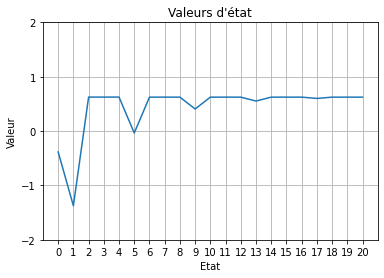

In [21]:
gamma = 0.99
nb_steps = 50

V = np.array([0 for _ in range(nb_states)])

for _ in range(nb_steps):
  V = np.amax(rewards + gamma*np.matmul(P,V), axis=0)

def affiche_valeurs_etats(states, V):
    plt.plot(states[:-1], V[:-1])
    plt.title("Valeurs d'état")
    plt.xlabel('Etat')
    plt.ylabel('Valeur')
    plt.xticks(states[:-1])
    plt.yticks([-2, -1, 0, 1, 2])
    plt.grid()
    plt.show()

affiche_valeurs_etats(states, V)

## 3) Calcul des valeurs d'actions

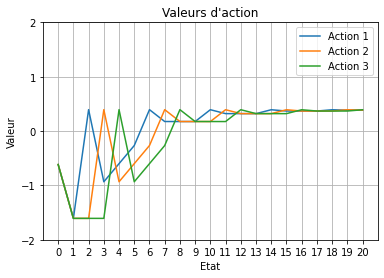

In [131]:
gamma = 0.99
nb_steps = 100

Q = np.zeros((nb_actions, nb_states))

for _ in range(nb_steps):
  Q = rewards + gamma*np.matmul(P, np.amax(Q, axis=0))

def affiche_valeurs_actions(states, Q):
    nb_actions = Q.shape[0]
    for i in range(nb_actions):
      plt.plot(states[:-1], Q[i, :-1])
    plt.legend(['Action 1', 'Action 2', 'Action 3'])
    plt.title("Valeurs d'action")
    plt.xlabel('Etat')
    plt.ylabel('Valeur')
    plt.xticks(states[:-1])
    plt.yticks([-2, -1, 0, 1, 2])
    plt.grid()
    
    plt.show()
    
affiche_valeurs_actions(states, Q)

# **II) Apprentissage par renforcement**

Ici, on ne connait plus le modèle. On dispose uniquement des récompenses que l'on peut récupérer lorsque l'on joue, et on va s'en servir pour estimer les valeurs d'état et d'action

## Environnement jeu de Nim

In [371]:
class NimGame:
    def __init__(self, nb_players=2, nb_sticks=20):
        self.nb_players = nb_players
        self.losers = np.zeros(nb_players)
        self.sticks_left = nb_sticks
        self.turn = 0

    def remove(self, sticks):
        self.sticks_left -= sticks
        if self.sticks_left < 1:
          self.losers[self.turn] = 1
        self.turn = (self.turn + 1) % self.nb_players

    def won(self, player_id):
        return self.losers[1-player_id] == 1

    def get_observation(self):
        return int(max(self.sticks_left, 0))


def environment_policy(actions):
    m = len(actions)
    return 0
    return np.random.choice(np.array([i for i in range(m)]))
    
class NimEnv:
    def __init__(self, nb_players=2, actions=(1,2,3), nb_sticks=20):
        self.nb_players = nb_players
        self.actions = actions
        self.nb_sticks = nb_sticks
        self.game = NimGame(nb_players=nb_players, nb_sticks=nb_sticks)
        
    def step(self, action_index):
        # Tour de l'agent
        observation = self.game.get_observation()
        reward = 0
        done = False
        self.game.remove(self.actions[action_index])
        
        # Si l'agent a perdu
        if self.game.won(1):
            done = True
            reward = -1
            
        elif self.game.won(0):
            done = True
            reward = 1
        
        # Sinon, ça continue
        elif not done:
            env_action = environment_policy(self.actions)
            self.game.remove(self.actions[env_action])
            
            if self.game.won(1):
                done = True
                reward = -1

            elif self.game.won(0):
                done = True
                reward = 1

        return observation, self.game.get_observation(), reward, done
    
    def reset(self):
        self.game = NimGame(nb_players=self.nb_players, nb_sticks=self.nb_sticks)
        

## Les différentes politiques

In [422]:
import random as rd

def avare(Q, current_state):
    return np.argmax(Q[:, current_state])

def epsilon_avare(Q, current_state, epsilon=0.1):
    m = Q.shape[0]
    action_max = np.argmax(Q[:, current_state])

    p = np.array([epsilon/m for i in range(m)])
    p[action_max] += (1 - epsilon)

    act = np.random.choice(np.array([i for i in range(m)]))
    return act

def random_policy(Q, current_state):
    m = Q.shape[0]
    return np.random.choice(np.array([i for i in range(m)]))

## 1) Méthode Monte Carlo

In [434]:
gamma = 0.99
alpha = 1e-2

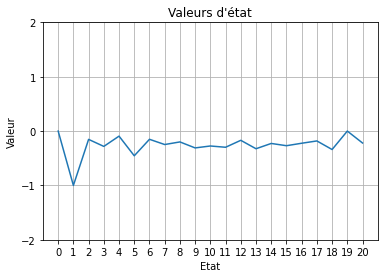

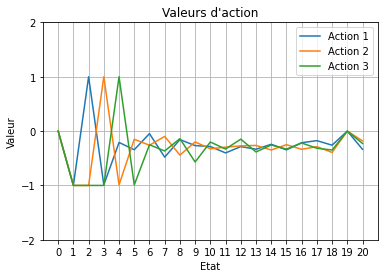

In [435]:
V = np.zeros(nb_states)
Q = np.zeros((nb_actions, nb_states))

nb_games = 10000

env = NimEnv()

for _ in range(nb_games):
    observation_history = np.array([]).astype(int)
    reward_history = np.array([])
    action_history = np.array([]).astype(int)

    done = False
    observation = 20

    while not done:
        action_agent = epsilon_avare(Q, env.game.get_observation())
        observation, next_observation, reward, done = env.step(action_agent)

        observation_history = np.append(observation_history, [observation])
        action_history = np.append(action_history, [action_agent])
        reward_history = np.append(reward_history, [reward])

    gain_0 = 0
    for i, reward in enumerate(reward_history):
        gain_0 += (gamma**i)*reward

    g_history = np.array([gain_0])
    for i, obs in enumerate(observation_history[1:]):
        gain_0 -= reward_history[i]
        gain_0 /= gamma
        g_history = np.append(g_history, [gain_0])

    for i, (obs, act) in enumerate(zip(observation_history, action_history)):
        g = g_history[i]
        V[obs] += alpha*(g - V[obs])
        Q[act][obs] += alpha*(g - Q[act][obs])
    
    env.reset()
    
        
affiche_valeurs_etats(states, V)
affiche_valeurs_actions(states, Q)

## 2) Différence temporelle

In [440]:
gamma = 0.99
alpha = 1e-2

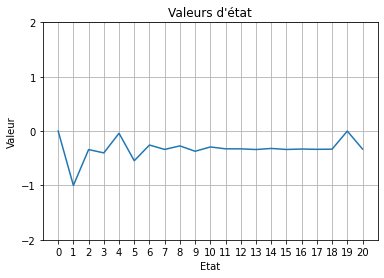

In [445]:
V = np.zeros(nb_states)
Q = np.zeros((nb_actions, nb_states))

nb_games = 10000

env = NimEnv()

for _ in range(nb_games):
    observation_history = np.array([]).astype(int)
    reward_history = np.array([])
    action_history = np.array([]).astype(int)

    done = False
    observation = env.game.get_observation()

    while not done:
        action_agent = random_policy(Q, env.game.get_observation())
        observation, next_observation, reward, done = env.step(action_agent)
        
        V[observation] += alpha*(reward + gamma*V[next_observation] - V[observation])

    env.reset()
        
affiche_valeurs_etats(states, V)

## 3) SARSA

In [ ]:
"""
V = np.zeros(nb_states)
Q = np.zeros((nb_actions, nb_states))

nb_games = 3000

env = NimEnv()

for _ in range(nb_games):
    observation_history = np.array([]).astype(int)
    reward_history = np.array([])
    action_history = np.array([]).astype(int)

    done = False
    observation = env.game.get_observation()

    while not done:
        action_agent = random_policy(Q, env.game.get_observation())
        observation, next_observation, reward, done = env.step(action_agent)
        
        next_Q_value = 0
        for a in actions:
            # Il faut juste implémenter ici la somme pondérée
            
        if done:
            Q[action_agent][observation] += alpha*(reward - Q[action_agent][observation])
        else:
            Q[action_agent][observation] += alpha*(reward + next_Q_value - Q[action_agent][observation])
    
    env.reset()
        
affiche_valeurs_actions(states, Q)
"""

## 4) Q-learning

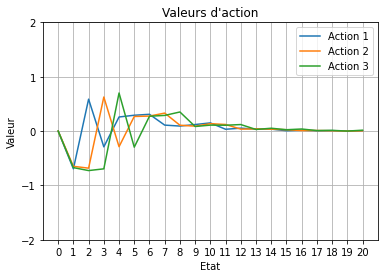

In [452]:
V = np.zeros(nb_states)
Q = np.zeros((nb_actions, nb_states))

nb_games = 1000

env = NimEnv()

for _ in range(nb_games):
    observation_history = np.array([]).astype(int)
    reward_history = np.array([])
    action_history = np.array([]).astype(int)

    done = False
    observation = env.game.get_observation()

    while not done:
        action_agent = epsilon_avare(Q, env.game.get_observation())
        observation, next_observation, reward, done = env.step(action_agent)
        
        next_action_max = avare(Q, next_observation)
        if done:
            Q[action_agent][observation] += alpha*(reward - Q[action_agent][observation])
        else:
            Q[action_agent][observation] += alpha*(reward + gamma*Q[next_action_max][next_observation] - Q[action_agent][observation])
    
    env.reset()
        
affiche_valeurs_actions(states, Q)